# 6.3. Diffusion Probabilistic Model

The materials in this notebook are inspired from:
* code
  * https://github.com/hojonathanho/diffusion
  * https://github.com/awjuliani/pytorch-diffusion
* article https://arxiv.org/abs/2006.11239

This tutorial covers the basics of Denoising Diffusion Probabilistic Models (DDPM). In a DDMP, the network learns to gradually denoise data:
* **Fixed forward diffusion process** gradually adds Gaussian noise to an image.
* **Generative reverse denoising process** gradually learns to denoise an image.

<img src="https://hojonathanho.github.io/diffusion/assets/img/pgm_diagram_xarrow.png">

This process (adding noise and denoising) happens at $T$ steps, a nice property of this process is that we can sample $X$ at any arbitrary $t$ step.

We explore a few new toy examples all in images of small resolution ($\le32 \times 32$):
* [MNIST](http://yann.lecun.com/exdb/mnist/): grey-scale digit recognition from 0 to 9.

<img src="https://www.researchgate.net/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png"  width="300" height="300">

* [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) grey-scale image recognition among 10 categories.

<img src="https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png"  width="300" height="300">

* [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html): object recognition among 10 categories.

<img src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png"  width="300" height="300">

# 0. Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [argparse](https://docs.python.org/3/library/argparse.html) is a module making it easy to write user-friendly command-line interfaces. 
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [os](https://docs.python.org/3/library/os.html) provides a portable way of using operating system-dependent functionality, e.g., modifying files/folders.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.

In [1]:
# importing the necessary packages/libraries
import numpy as np
import argparse
from matplotlib import pyplot as plt
import random
import os
import math

import torch
import torch.nn as nn
import torch.nn.functional as torch_f
import torchvision

## device

Choosing CPU or GPU based on the availability of the hardware.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## arguments

We use the `argparse` module to define a set of parameters that we use throughout this notebook:
* The `argparse` is particularly useful when writing Python scripts, allowing you to run the same script with different parameters (e.g., for doing different experiments).
* In notebooks using `argparse` is not necessarily beneficial, we could have hard-coded those values directly in variables, but here we use `argparse` for learning purposes.

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=2e-4, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.9, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--diffusion_steps", type=int, default=1000, help="number of diffusion steps")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=500, help="interval between image sampling")
parser.add_argument("--out_dir", type=str, default="./dmp_out/", help="the output directory")
parser.add_argument("--dataset", type=str, default="mnist", 
                    choices=["mnist", "fashion-mnist", "cifar10"], help="which dataset to use")

def set_args(*args):
    # we can pass arguments to the parse_args function to change the default values. 
    opt = parser.parse_args([*args])
    # adding the dataset to the out dir to avoid overwriting the generated images
    opt.out_dir = "%s/%s/" % (opt.out_dir, opt.dataset)
    
    # the images in cifar10 are colourful
    if opt.dataset == "cifar10":
        opt.channels = 3
    
    # creating the output directory
    os.makedirs(opt.out_dir, exist_ok=True)
    return opt

In [4]:
opt = set_args("--n_epochs", "10", "--dataset", "mnist")
print(opt)

Namespace(n_epochs=10, batch_size=128, lr=0.0002, b1=0.9, b2=0.999, diffusion_steps=1000, img_size=32, channels=1, sample_interval=500, out_dir='./dmp_out//mnist/', dataset='mnist')


# Architecture

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, h_size):
        super(SelfAttention, self).__init__()
        self.h_size = h_size
        self.mha = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )

    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value


class SAWrapper(nn.Module):
    def __init__(self, h_size, num_s):
        super(SAWrapper, self).__init__()
        self.sa = nn.Sequential(*[SelfAttention(h_size) for _ in range(1)])
        self.num_s = num_s
        self.h_size = h_size

    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s * self.num_s).swapaxes(1, 2)
        x = self.sa(x)
        x = x.swapaxes(2, 1).view(-1, self.h_size, self.num_s, self.num_s)
        return x


# U-Net code adapted from: https://github.com/milesial/Pytorch-UNet


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        return torch_f.gelu(x + self.double_conv(x)) if self.residual else self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, in_channels, residual=True)
            self.conv2 = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch_f.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x

In [6]:
class DiffusionModel(nn.Module):
    def __init__(self, opt):
        super(DiffusionModel, self).__init__()
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.t_range = opt.diffusion_steps
        self.in_size = opt.img_size ** 2

        bilinear = True
        self.inc = DoubleConv(opt.channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, opt.channels, kernel_size=1)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=device).float() / channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t):
        """Model is U-Net with added positional encodings and self-attention layers."""
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32)
        output = self.outc(x)
        return output

    def beta(self, t):
        return self.beta_small + (t / self.t_range) * (self.beta_large - self.beta_small)

    def alpha(self, t):
        return 1 - self.beta(t)

    def alpha_bar(self, t):
        return math.prod([self.alpha(j) for j in range(t)])

    def get_loss(self, batch): # TODO batch_idx
        """Corresponds to Algorithm 1 from (Ho et al., 2020)."""
        # for each sample in the batch we create a random time step t
        ts = torch.randint(0, self.t_range, [batch.shape[0]], device=device)
        
        # the fixed forward diffusion process gradually adds Gaussian noise to an image.
        noise_imgs = []
        epsilons = torch.randn(batch.shape, device=device)
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noise_imgs.append((math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i]))
        noise_imgs = torch.stack(noise_imgs, dim=0)
        
        # the generative reverse denoising process gradually learns to denoise an image.
        e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float))

        # computing the loss
        loss = torch_f.mse_loss(e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size))
        return loss

    def denoise_sample(self, x, t):
        """Corresponds to the inner loop of Algorithm 2 from (Ho et al., 2020)."""
        with torch.no_grad():
            z = torch.randn(x.shape, device=device) if t > 1 else 0
            e_hat = self.forward(x, t.view(1, 1).repeat(x.shape[0], 1))
            pre_scale = 1 / math.sqrt(self.alpha(t))
            e_scale = (1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))
            post_sigma = math.sqrt(self.beta(t)) * z
            x = pre_scale * (x - e_scale * e_hat) + post_sigma
            return x

# Dataset

We explore three datasets all already implemented in `torchvision`. The first time will be automatically downloaded (in *"./data/"* directory) the first time if already it doesn't exist.

In [7]:
def get_dataloader(opt, transform):
    if opt.dataset == "mnist":
        dataset = torchvision.datasets.MNIST("./data/", train=True, download=True, transform=transform)
    elif opt.dataset == "fashion-mnist":
        dataset = torchvision.datasets.FashionMNIST("./data/", train=True, download=True, transform=transform)
    else:
        dataset = torchvision.datasets.cifar.CIFAR10("./data/", train=True, download=True, transform=transform)
    return torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=True)

## Transform functions

We resize all images to specified image size (`opt.img_size`), converting them to `Tensor` and normalising the inputs (`Normalize`).

In [8]:
# make the pytorch datasets
mean = 0.5
std = 0.5
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(opt.img_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

dataloader = get_dataloader(opt, transform)

## Visualisation

Let's visualise a few samples from our dataset.

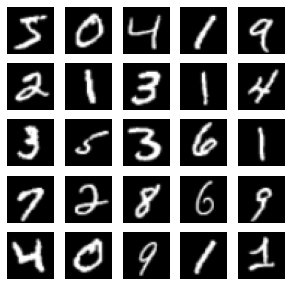

In [9]:
fig = plt.figure(figsize=(5, 5))
for i in range(25):
    img, target = dataloader.dataset.__getitem__(i)
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img.numpy().transpose(1, 2, 0) * std + mean, cmap='gray')
    ax.axis('off')

# Training

## Setup Networks and Optimiser

In [10]:
def setup_training(opt):
    # Initialise network
    network = DiffusionModel(opt).to(device)

    # Optimiser
    optimizer = torch.optim.Adam(network.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

    return network, optimizer

## Utility functions

In [11]:
def sample_image(model, batches_done, opt, saveimg=False, samples=10, steps=15):
    """Saves a grid of generated images."""
    x = torch.randn((samples, opt.channels, opt.img_size, opt.img_size)).to(device)
    diffusion_steps = torch.arange(model.t_range-1, 0, -1).to(device)
    tosave_steps = [*diffusion_steps[::len(diffusion_steps) // steps], diffusion_steps[-1]]
    gen_imgs = []
    with torch.no_grad():
        for t in diffusion_steps:
            x = model.denoise_sample(x, t)
            if t in tosave_steps:
                gen_imgs.append(x)
    gen_imgs = torch.stack(gen_imgs, dim=0)
    if saveimg:
        gen_imgs = gen_imgs.view(-1, opt.channels, opt.img_size, opt.img_size)
        torchvision.utils.save_image(
            gen_imgs.data, "%s/%.7d.png" % (opt.out_dir, batches_done), nrow=10, normalize=True
        )
    else:
        return gen_imgs, tosave_steps

The training loop follows standard steps. The only difference is that we call the `network.get_loss()`  function instead of the usual calling of the `forward` function by passing inputs to the `network`.: 
* The `get_loss` function internally calls the `forward` function.
* The `get_loss` function also computes the loss value using MSE and returns it.

In [12]:
def train_instance(opt):
    network, optimiser = setup_training(opt)

    losses = []
    for epoch in range(opt.n_epochs):
        for batch_ind, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)
            
            loss = network.get_loss(imgs)
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
    
            losses.append(loss.item())
    
            batches_done = epoch * len(dataloader) + batch_ind
            if batches_done % opt.sample_interval == 0:
                sample_image(network, batches_done, opt, saveimg=True)
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [loss: %f]"
                    % (epoch, opt.n_epochs, batch_ind, len(dataloader), np.mean(losses))
                )
    return network, losses

# Results

Let's train our DDPM with current arguments (`opt`).

Training progress:
* **loss value** we can observe that the MSE (L2 norm) is gradually decreasing.
* **reconstructed images** By looking at the reconstructed images (in the `opt.out_dir` folder), we can observe that the quality of generated images is quite good. In other words, the network has learnt to denoise the input at each diffusion step.

In [13]:
model, losses = train_instance(opt)

[Epoch 0/10] [Batch 0/469] [loss: 1.364887]
[Epoch 1/10] [Batch 31/469] [loss: 0.093262]
[Epoch 2/10] [Batch 62/469] [loss: 0.063589]
[Epoch 3/10] [Batch 93/469] [loss: 0.052443]
[Epoch 4/10] [Batch 124/469] [loss: 0.046110]
[Epoch 5/10] [Batch 155/469] [loss: 0.042119]
[Epoch 6/10] [Batch 186/469] [loss: 0.039171]
[Epoch 7/10] [Batch 217/469] [loss: 0.036970]
[Epoch 8/10] [Batch 248/469] [loss: 0.035148]
[Epoch 9/10] [Batch 279/469] [loss: 0.033649]


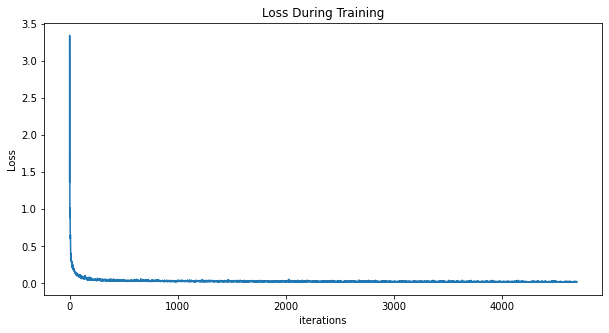

In [14]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

## Generating

In [15]:
def normalise(x, low= 0, high=1):
    """Normalise a signal between the low and high values."""
    minv = np.min(x)
    maxv = np.max(x)
    # This is the equation for min-max normalisation https://en.wikipedia.org/wiki/Feature_scaling
    return low + (x - minv) * (high - low) / (maxv - minv)

def plot_gen_imgs(gen_imgs):
    gen_imgs = normalise(gen_imgs)
    
    fig = plt.figure(figsize=(18, 8))
    ax_ind = 1
    for i in range(gen_imgs.shape[1]):
        for t in range(gen_imgs.shape[0]):
            ax = fig.add_subplot(gen_imgs.shape[1], gen_imgs.shape[0], ax_ind)
            ax.imshow(gen_imgs[t, i], cmap='gray')
            ax.axis('off')
            ax_ind += 1
            if i == 0:
                ax.set_title("$T=%d$" % steps[t] if t == 0 else "$%d$" % steps[t])

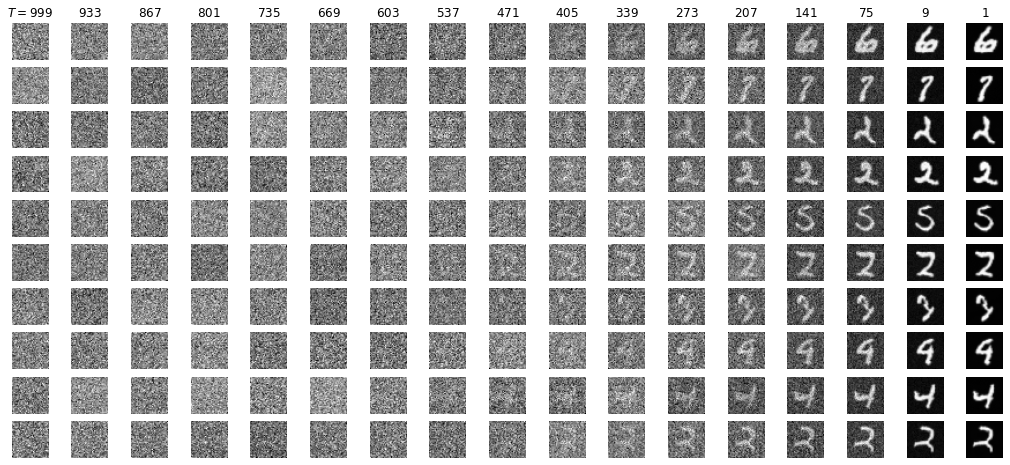

In [16]:
gen_imgs, steps = sample_image(model, None, opt, saveimg=False)
gen_imgs = gen_imgs.detach().cpu().numpy().transpose(0, 1, 3, 4, 2)
plot_gen_imgs(gen_imgs)

# Another dataset

Let's play with another dataset!

Namespace(n_epochs=30, batch_size=128, lr=0.0002, b1=0.9, b2=0.999, diffusion_steps=1000, img_size=32, channels=3, sample_interval=500, out_dir='./dmp_out//cifar10/', dataset='cifar10')
Files already downloaded and verified


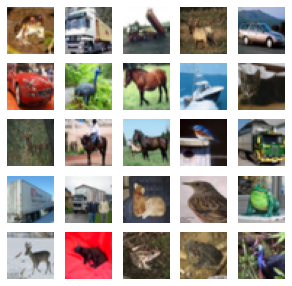

In [17]:
opt = set_args("--n_epochs", "30", "--dataset", "cifar10")
print(opt)

dataloader = get_dataloader(opt, transform)

fig = plt.figure(figsize=(5, 5))
for i in range(25):
    img, target = dataloader.dataset.__getitem__(i)
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img.numpy().transpose(1, 2, 0) * std + mean, cmap='gray')
    ax.axis('off')

In [18]:
model, losses = train_instance(opt)

[Epoch 0/30] [Batch 0/391] [loss: 1.502118]
[Epoch 1/30] [Batch 109/391] [loss: 0.133310]
[Epoch 2/30] [Batch 218/391] [loss: 0.095016]
[Epoch 3/30] [Batch 327/391] [loss: 0.079812]
[Epoch 5/30] [Batch 45/391] [loss: 0.071379]
[Epoch 6/30] [Batch 154/391] [loss: 0.065934]
[Epoch 7/30] [Batch 263/391] [loss: 0.062047]
[Epoch 8/30] [Batch 372/391] [loss: 0.059087]
[Epoch 10/30] [Batch 90/391] [loss: 0.056777]
[Epoch 11/30] [Batch 199/391] [loss: 0.054932]
[Epoch 12/30] [Batch 308/391] [loss: 0.053386]
[Epoch 14/30] [Batch 26/391] [loss: 0.052062]
[Epoch 15/30] [Batch 135/391] [loss: 0.050902]
[Epoch 16/30] [Batch 244/391] [loss: 0.049908]
[Epoch 17/30] [Batch 353/391] [loss: 0.048988]
[Epoch 19/30] [Batch 71/391] [loss: 0.048224]
[Epoch 20/30] [Batch 180/391] [loss: 0.047470]
[Epoch 21/30] [Batch 289/391] [loss: 0.046828]
[Epoch 23/30] [Batch 7/391] [loss: 0.046280]
[Epoch 24/30] [Batch 116/391] [loss: 0.045746]
[Epoch 25/30] [Batch 225/391] [loss: 0.045249]
[Epoch 26/30] [Batch 334/391]

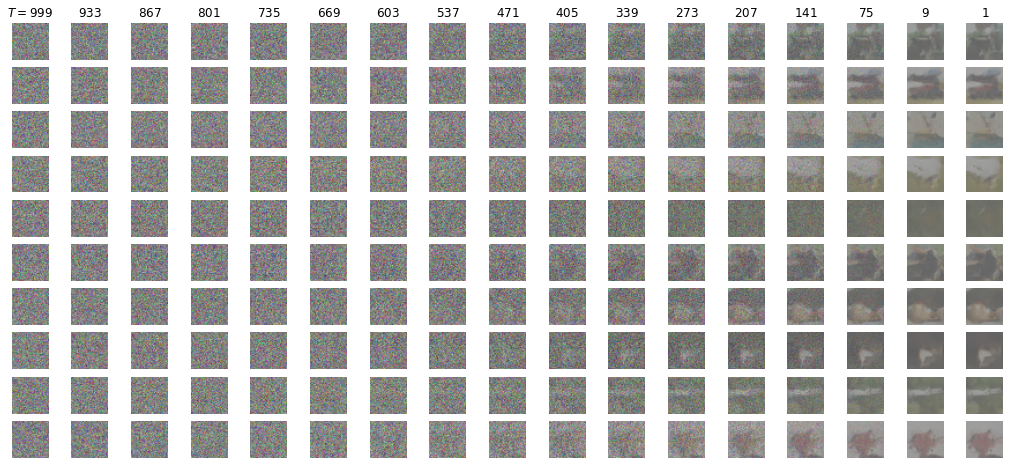

In [19]:
gen_imgs, steps = sample_image(model, None, opt, saveimg=False)
gen_imgs = gen_imgs.detach().cpu().numpy().transpose(0, 1, 3, 4, 2)
plot_gen_imgs(gen_imgs)